In [1]:
# expand cells to the 95% of the display width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 95% !important; }</style>"))

# Tutorial: Automatic rule-based modeling of the *Escherichia coli* lactose metabolism, including protein-protein interactions and regulation of gene expression employing *Atlas*

Authors: Rodrigo Santibáñez[1,2], Daniel Garrido[2], and Alberto Martín[1]

Date: August 2020

Affiliations:
1. Centro de Genómica y Bioinformática, Facultad de Ciencias, Universidad Mayor, Santiago, 8580745, Chile.
2. Department of Chemical and Bioprocess Engineering, School of Engineering, Pontificia Universidad Católica de Chile, Santiago, 7820436, Chile

Notes: This tutorial was created for the manuscript "*Atlas*: Automatic modeling of regulation of bacterial gene expression and metabolism using rule-based languages", first submitted for peer-review to Bioinformatics on May, 2020.

## Prerequisites

0. The tutorial was prepared and executed on Ubuntu 20.04, PathwayTools version 24, and docker engine version 19.03.8.<br/><br/>

1. PathwayTools must be installed and running to obtain data from the EcoCyc database. Please, run ```pathway-tools -lisp -python-local-only``` before to obtain any data.<br/>
   (Optional) The PathwayTools software could be executed in the background, with help of ```nohup pathway-tools -lisp -python-local-only > /dev/null 2> /dev/null &```.<br/>
   Please follow instructions at http://pathwaytools.org/ to obtain a licensed copy of the software from https://biocyc.org/download-bundle.shtml. However, data could be manually formatted using a text-based editor or a spreadsheet software.
   
   Note: If you ran into the ```pathway-tools/aic-export/pathway-tools/ptools/22.5/exe/aclssl.so: undefined symbol: CRYPTO_set_locking_callback``` error, please follow instructions here: https://github.com/glucksfall/atlas/tree/master/PTools. Instructions will guide you to install a docker image that is able to run pathway tools, but does not include it, so you still need to obtain the software with a valid license.<br/><br/>
   
2. (Highly recommended) Install Docker. Please follow instructions for a supported Operating System https://docs.docker.com/engine/install/:<br/>
   On Ubuntu, install it with ```apt-get install docker.io```.<br/>
   On Win10, install Docker Desktop with WSL2 support https://docs.docker.com/docker-for-windows/wsl/.<br/>
   On MacOS, install Docker Desktop https://docs.docker.com/docker-for-mac/install/.<br/><br/>
   The Docker ```networkbiolab/pleiades```installs the python packages, the jupyter server, and the stochastic simulators.<br/><br/>

3. (Recommended) Jupyter notebook. We recommend the use of Anaconda3 https://www.anaconda.com/products/individual because of the easier installation of the stochastic simulators from https://anaconda.org/alubbock.<br/><br/>

4. (Optional) A stochastic simulator, supported by the pySB python package ([BNG2](https://github.com/RuleWorld/bionetgen), [NFsim](https://github.com/ruleworld/nfsim/tree/9178d44455f6e27a81f398074eeaafb2a1a4b4bd), [KaSim](https://github.com/Kappa-Dev/KappaTools) or [Stochkit](https://github.com/StochSS/StochKit)). pySB requires BNG2 to simulate models with NFsim.<br/><br/>

5. (Optional) Cytoscape to visualize metabolic networks and others.

## Preamble: load *Atlas*

In [2]:
# testing source code
import sys
sys.path.append("..") # If installed from GitHub and this notebooks is executed from the tutorial directory.

import atlas_rbm.atlas as atlas
import atlas_rbm.utils as utils
import atlas_rbm.export as export
import atlas_rbm.simulation as simulation

## Modeling metabolism

In this tutorial, we will model the metabolism of lactose degradation in *Escherichia coli* as a test-bed of the software Atlas. Moreover, we will couple the metabolism to the protein-protein interactions and gene expression and regulations that occurs naturally in the bacteria. We choose the lactose metabolism since it was discovered in the decade of 1960s and it is a common model of gene regulation with more than 50 years of biochemical information. In an side note, the characterization of the lactose operon and others rewarded their authors the 1965 Nobel Prize in Physiology or Medicine (https://www.nobelprize.org/prizes/medicine/1965/summary/)

The lactose operon from *E. coli* consists of three genes: the $\beta$-galactosidase gene lacZ, the lactose permease gene lacY (also known as lactose-proton symporter), and the galactoside O-acetyltransferase gene lacA:

In [3]:
%time network = utils.read_network('network-lac-metabolism-enzymes.tsv')
network

CPU times: user 5.46 ms, sys: 484 µs, total: 5.94 ms
Wall time: 5.39 ms


,GENE OR COMPLEX,ENZYME LOCATION,REACTION,SUBSTRATES,PRODUCTS,FWD_RATE,RVS_RATE
0,spontaneous,cytosol,LACTOSE-MUTAROTATION,alpha-lactose,beta-lactose,1,1
1,spontaneous,cytosol,GALACTOSE-MUTAROTATION,alpha-GALACTOSE,beta-GALACTOSE,1,1
2,spontaneous,cytosol,GLUCOSE-MUTAROTATION,alpha-glucose,beta-glucose,1,1
3,LACY-MONOMER,inner membrane,TRANS-RXN-24,"PER-PROTON,PER-alpha-lactose","PROTON,alpha-lactose",1,0
4,LACY-MONOMER,inner membrane,TRANS-RXN-24-beta,"PER-PROTON,PER-beta-lactose","PROTON,beta-lactose",1,0
5,LACY-MONOMER,inner membrane,TRANS-RXN-94,"PER-PROTON,PER-MELIBIOSE","PROTON,MELIBIOSE",1,0
6,LACY-MONOMER,inner membrane,RXN0-7215,"PER-PROTON,PER-CPD-3561","PROTON,CPD-3561",1,0
7,LACY-MONOMER,inner membrane,RXN0-7217,"PER-PROTON,PER-CPD-3785","PROTON,CPD-3785",1,0
8,LACY-MONOMER,inner membrane,RXN-17755,"PER-PROTON,PER-CPD-3801","PROTON,CPD-3801",1,0
9,BETAGALACTOSID-CPLX,cytosol,BETAGALACTOSID-RXN,"beta-lactose,WATER","beta-GALACTOSE,beta-glucose",1,0


The ```utils.metabolicNetwork.expand_network``` function reorders and exports the dataframe as a text file (in this case to ```./tutorial.txt```).

In [4]:
%time utils.metabolicNetwork.expand_network(network, './lactose-metabolism-cytoscape-v3.txt')

CPU times: user 1.91 ms, sys: 0 ns, total: 1.91 ms
Wall time: 1.44 ms


<img src="lactose-metabolism-cytoscape-v3.png" alt="drawing" width="750"/>

Now we have the network, we could build the rule-based model from the source or the DataFrame:

In [5]:
%time model = atlas.construct_model_from_metabolic_network(network, verbose = False) # use the dataframe to build the model
model

CPU times: user 695 ms, sys: 32.2 ms, total: 727 ms
Wall time: 726 ms


<Model 'atlas_rbm.construct_model_from_metabolic_network' (monomers: 3, rules: 18, parameters: 59, expressions: 0, compartments: 0) at 0x7fce88ab33d0>

In [6]:
%time model = atlas.construct_model_from_metabolic_network('network-lac-metabolism-enzymes.tsv', verbose = False) # read a file to build a model
model

CPU times: user 654 ms, sys: 11.3 ms, total: 665 ms
Wall time: 663 ms


<Model 'atlas_rbm.construct_model_from_metabolic_network' (monomers: 3, rules: 18, parameters: 59, expressions: 0, compartments: 0) at 0x7fce889cdbe0>

To simulate, we need to set the initial condition:

In [7]:
# initial condition
# for metabolites
simulation.set_initial.met(model, 'beta_lactose', 'per', 100)
simulation.set_initial.met(model, 'PROTON', 'per', 100) # required for lactose transport
simulation.set_initial.met(model, 'WATER', 'cyt', 100) # required for lactose hydrolysis

# for proteins
simulation.set_initial.prot(model, 'LACY_MONOMER', 'imem', 1)
simulation.set_initial.cplx(model, 'GALACTOACETYLTRAN_CPLX', 'cyt', 1)
simulation.set_initial.cplx(model, 'BETAGALACTOSID_CPLX', 'cyt', 1)

Initial t0_met_beta_lactose not found. Creating Initial t0_met_beta_lactose...
Initial t0_met_PROTON not found. Creating Initial t0_met_PROTON...
Initial t0_prot_LACY_MONOMER not found. Creating Initial t0_prot_LACY_MONOMER...


<Model 'atlas_rbm.construct_model_from_metabolic_network' (monomers: 3, rules: 18, parameters: 62, expressions: 0, compartments: 0) at 0x7fce889cdbe0>

In [8]:
# simulation
bng = '/opt/git-repositories/bionetgen.RuleWorld/bng2/'
kasim = '/opt/git-repositories/KaSim4.Kappa-Dev/'

%time data1 = simulation.scipy(model, start = 0, finish = 10, points = 500)
%time data2 = simulation.bngSSA(model, start = 0, finish = 10, points = 500, n_runs = 100, path = bng)

CPU times: user 3.46 s, sys: 820 ms, total: 4.28 s
Wall time: 3.9 s
CPU times: user 5.14 s, sys: 133 ms, total: 5.28 s
Wall time: 10.2 s


Finally, we plot the simulation results. The result of the ```simulation.ode()``` function is a pandas dataframe. In the case of stochastic simulations (SSA, KaSim, NFsim, Stochkit), the function returns a dictionary with a list of dataframe for each simulations (```sims``` key), and dataframe with the average (```avrg``` key) and a dataframe with the standard deviation (```stdv``` key) of those simulations. Currently, we included three kind of plots, although the user could access the dataframes and plot diretly with methods in the seaborn package (https://seaborn.pydata.org/), in the pandas package (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html), or with matplotlib (https://matplotlib.org/).

In [9]:
import seaborn
import matplotlib.pyplot as plt

for key in [
#     'figure.titlesize',
    'font.size',
#     'legend.fontsize',
#     'legend.title_fontsize',
    'font.size', 
#     'xtick.labelsize',
    'xtick.major.size',
    'xtick.minor.size',
#     'ytick.labelsize',
    'ytick.major.size',
    'ytick.minor.size']:
    plt.rcParams[key] = plt.rcParams[key] * 1.1

palette = seaborn.color_palette('colorblind')

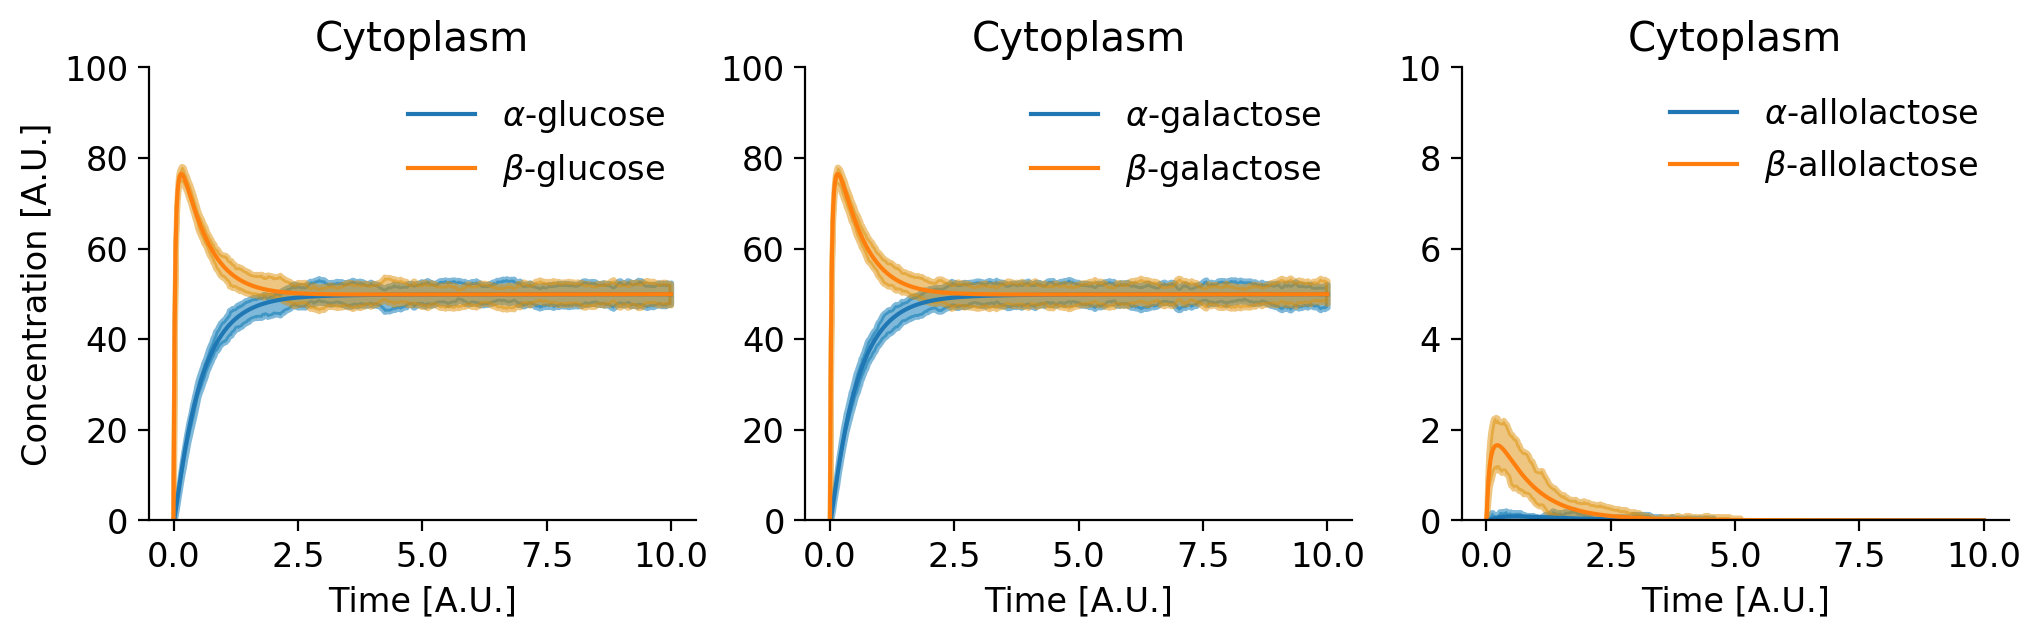

In [10]:
kind = 'fill_between'
fig, ax = plt.subplots(1, 3, figsize = (4*3, 3*1), dpi = 200)

# first plot, lactose concentration
simulation.plot.metabolite(data1, 'alpha-glucose', 'cyt', ax = ax[0], plt_kws = {'label' : r'$\alpha$-glucose'})
simulation.plot.metabolite(data1, 'beta-glucose', 'cyt', ax = ax[0], plt_kws = {'label' : r'$\beta$-glucose'})

simulation.plot.metabolite(
    data2, 'alpha-glucose', 'cyt', ax = ax[0], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[0], 'alpha' : .5})

simulation.plot.metabolite(
    data2, 'beta-glucose', 'cyt', ax = ax[0], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[1], 'alpha' : .5})

# second plot, galactose concentration
simulation.plot.metabolite(data1, 'alpha-GALACTOSE', 'cyt', ax = ax[1], plt_kws = {'label' : r'$\alpha$-galactose'})
simulation.plot.metabolite(data1, 'beta-GALACTOSE', 'cyt', ax = ax[1], plt_kws = {'label' : r'$\beta$-galactose'})

simulation.plot.metabolite(
    data2, 'alpha-GALACTOSE', 'cyt', ax = ax[1], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[0], 'alpha' : .5})

simulation.plot.metabolite(
    data2, 'beta-GALACTOSE', 'cyt', ax = ax[1], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[1], 'alpha' : .5})

# third plot, allolactose concentration
simulation.plot.metabolite(data1, 'alpha-ALLOLACTOSE', 'cyt', ax = ax[2], plt_kws = {'label' : r'$\alpha$-allolactose'})
simulation.plot.metabolite(data1, 'beta-ALLOLACTOSE', 'cyt', ax = ax[2], plt_kws = {'label' : r'$\beta$-allolactose'})

simulation.plot.metabolite(
    data2, 'alpha-ALLOLACTOSE', 'cyt', ax = ax[2], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[0], 'alpha' : .5})

simulation.plot.metabolite(
    data2, 'beta-ALLOLACTOSE', 'cyt', ax = ax[2], **{'kind' : kind, 'weight' : 0.5}, 
    plt_kws = {'s' : 2, 'color' : palette[1], 'alpha' : .5})

ax[0].set_xlabel('Time [A.U.]')
ax[0].set_ylabel('Concentration [A.U.]')
ax[0].set_title('Cytoplasm')
ax[0].set_ylim(top = 100, bottom = 0)

ax[1].set_xlabel('Time [A.U.]')
ax[1].set_title('Cytoplasm')
ax[1].set_ylim(top = 100, bottom = 0)

ax[2].set_xlabel('Time [A.U.]')
ax[2].set_title('Cytoplasm')
ax[2].set_ylim(top = 10, bottom = 0)

ax[0].legend(frameon = False)
ax[1].legend(frameon = False)
ax[2].legend(frameon = False)

seaborn.despine()
plt.show()

As expected, the degradation of lactose into glucose and galactose is complete because most reactions are irreversible, while mutarotation allows equilibrium of anomers. However, we must note that we considered the enzymatic reactions are performed by its complex (e.g. four monomers of LacZ catalyze one reaction), although biochemical information informs the monomers are catalytically active only when the complex is assembled (e.g. one LacZ tetramer catalyzes four reactions). This will be considered next, when we will model protein-protein interactions.

Please, continue the tutorial opening the `tutorial - 1B - lactose degradation.ipynb` notebook where we will show how to model protein-protein interactions and merge it with metabolic models.